# I-V-Curve of a PV Cell from a Two-Diode-Model 

This notebook follows the subsection on the two-diode-model for PV cells from V. Quasching's book "Renwable Energy Systems". 
<br>
The model model leads to an implicit equation for I(V): I cannot be moved solely on one side of the equation.
<br>
The equation has to be solved numerically. We use the Newton method from Scipy.
<br>
We have to find a combination (I,V) such that f(I,V) = 0.

## The 2-Diode Model with Parasitic Resistances

<img src="./images/PV_Cell_2_Diode_Model_V001.png" width=400/>

The parallel and series resistors $R_P$ and $R_S$ describe parasitic losses and express the non-ideal behaviour of a real PV cell. 

The photo current $I_\mathrm{ph}$ is coming from the photoelectric effect. It is the power source. It can be assumed that the photo current is proportional to the irradiance $E$ in W/m²:

$
I_\mathrm{ph} = c_0E
$

The parameter $c_0$ describes the efficiency, i.e. how many Amperes are created per unt area of the PV cell when the irradiance is $E$.

The voltage $V$ and current $I$ are measured at the terminals of the PV cell.

The voltage $V_D$ across the diodes $D_1$ and $D_2$ and the parallel resistance $R_P$ (at the node where these components join) is: 

$V_D = V + R_S I$

The voltage $V_D$ depends also on $I$. 

The current equation (Kirchhoff junction rule) is:

$
I_\mathrm{ph} - I_{D_1} - I_{D_2} - I_{R_P} - I = 0
$

The single Shockley diode model used is:

$
I_D(V_D) = I_s \left(e^{V_D/(m V_T)} -1 \right)
$

with parameters:
* $V_D$: voltage across diode, forward or reverse bias or 0V
* $I_s$: saturation current, leaking current in reverse bias 
* $m$: shape parameter, determines how fast the exponential grows (aka ideality factor)
* $V_T$: temperature dependent voltage parameter, $eV_T = kT$

The current flowing through the resistor $R_P$ is also dependent on $V_D$:

$
I_{R_P} = V_D/R_P
$

### Characteristic V-I-Curve of a PV Cell

The question is: **What is $I(V)$?**

Move $I$ to the left side and substitute the functions:


$
I = I_\mathrm{ph}(E) - I_{D_1}(V,I) - I_{D_2}(V,I) - I_{R_P}(V,I)
$

$
0 = I_\mathrm{ph}(E) - I_{D_1}(V,I) - I_{D_2}(V,I) - I_{R_P}(V,I) - I
$

$
\mathrm{err} = I_\mathrm{ph}(E) - I_{D_1}(V,I) - I_{D_2}(V,I) - I_{R_P}(V,I) - I
$



$
I = 
c_0 E + 
I_{s_1} \left(e^{\frac{[V + R_S I]}{m_1 V_T}} -1 \right) +
I_{s_2} \left(e^{\frac{[V + R_S I]}{m_2 V_T}} -1 \right) +
\frac{[V + R_S I]}{R_P}
$

$I(V) = ???
$

In [24]:
import scipy as sc
from scipy.optimize import newton
import numpy as np
import matplotlib.pyplot as plt

In [25]:
from scipy.constants import k,e
print(f"{e = :.3e} C")
print(f"{k = :.3e} J/K")

e = 1.602e-19 C
k = 1.381e-23 J/K


## Evaluation of the Single Diode Model

The model is:

$
I_D = I_s \left(e^{V/(m V_T)} -1 \right)
$


In [26]:
# Single Diode Model
def ID(V, Is, m, T=300):
    from scipy.constants import k, e
    from numpy import exp
    VT=k*T/e
    return Is*(exp(V/(m*VT))-1)

In [27]:
# Parameters of two example diodes 
Is1=1.913e-9
m1=1

Is2=8.25e-6
m2=2

# Cell temperature assumption
T = 300

In [28]:
# The voltage range for the analysis
V = np.linspace(0,0.8,100)

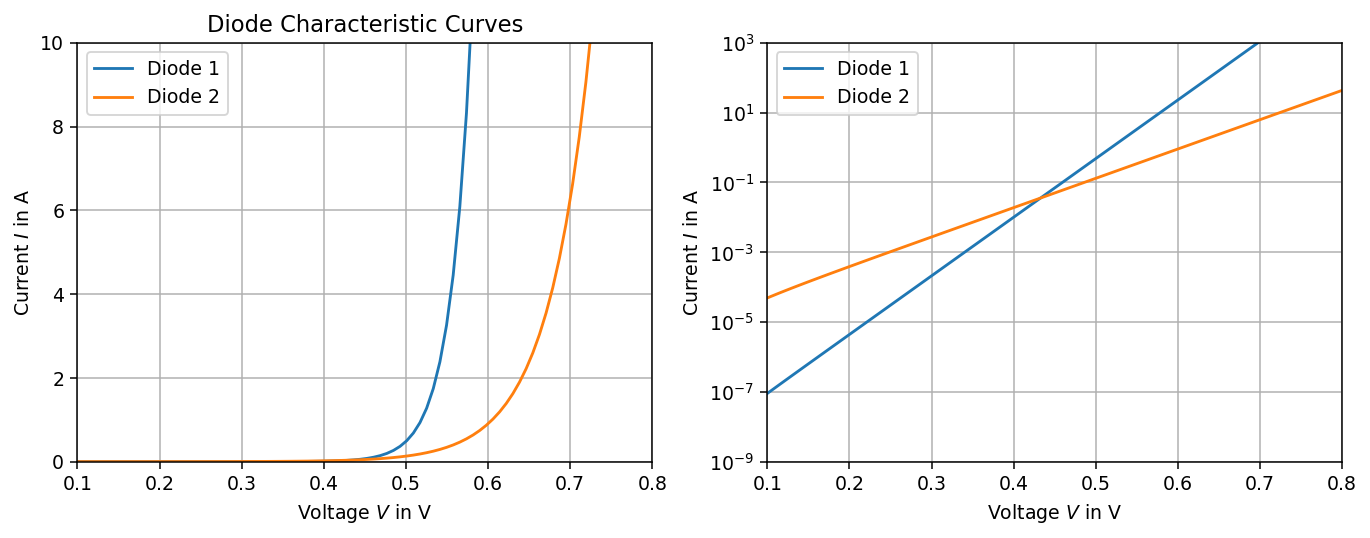

In [29]:
fig, ax = plt.subplots(1,2,figsize=(12,4), dpi=136)

ax[0].plot(V,ID(V,Is1, m1, T), label="Diode 1")
ax[0].plot(V,ID(V,Is2, m2, T), label="Diode 2")
ax[0].set_xlim(0.1,0.8)
ax[0].set_ylim(0,10)
ax[0].set_xlabel(r"Voltage $V$ in V")
ax[0].set_ylabel(r"Current $I$ in A")
ax[0].legend()
ax[0].grid(True)

ax[1].semilogy(V,ID(V,Is1, m1, T), label="Diode 1")
ax[1].semilogy(V,ID(V,Is2, m2, T), label="Diode 2")
ax[1].set_xlim(0.1,0.8)
ax[1].set_ylim(1e-9,1e3)
ax[1].set_xlabel(r"Voltage $V$ in V")
ax[1].set_ylabel(r"Current $I$ in A")
ax[1].legend()
ax[1].grid(True)

ax[0].set_title(r"Diode Characteristic Curves")

plt.show()

## Netwon's Method to Solve Implicit Equations

Newton's method tries to find the roots of a function, i.e. at which $x$-values $y = f(x)$ becomes 0. The implicit problem is transformed in a new problem in which $I$ such that the new function becomes 0. This $I$ is then the solution of the original problem. 

Find $I$ such that the output of the error function below becomes almost 0.

In [35]:
# Find I such that the output of the error function below becomes almost 0.
# default PV cell model values: Kyocera LA441J59, from Quaschning, Renewable Energy Systems

def PVmodel02impl(I=0, V=0, E=1000, T=300, c0=3.09e-3, Is1=1.913e-9, Is2=8.25e-6, m1=1, m2=2, Rs=12.94e-3, Rp=94.1):
    from numpy import exp
    from scipy.constants import k,e

    Iph=c0*E
    VT=k*T/e
    
    VD=V+I*Rs

    error = Iph - ID(VD,Is1,m1,T) - ID(VD,Is2,m2,T) - VD/Rp - I
    
    return(error)

**Implicit Function Problem**

Try to find $I$ for a given voltage $V$ such that the function `PVmodel02impl(I, V) = 0`. Guess $I$! Wow small can you make the error?

In [36]:
# Set example voltage:
V = 0.4 #V

In [40]:
# Guess No. 1 of I
I = 3.2
error = PVmodel02impl(I, V)
print(f"{error = :.3e}")

error = -2.065e-01


In [41]:
# Guess No. 2 of I
I = 3.0
error = PVmodel02impl(I, V)
print(f"{error = :.3e}")

error = 2.788e-04


In [39]:
# Guess No. 3 of I
I = 3.0001
error = PVmodel02impl(I, V)
print(f"{error = :.3e}")

error = 1.755e-04


**Exercise: Go on!** How close can you get to 0?

## Apply the Newton Method

In [12]:
help(newton)

Help on function newton in module scipy.optimize._zeros_py:

newton(func, x0, fprime=None, args=(), tol=1.48e-08, maxiter=50, fprime2=None, x1=None, rtol=0.0, full_output=False, disp=True)
    Find a zero of a real or complex function using the Newton-Raphson
    (or secant or Halley's) method.
    
    Find a zero of the scalar-valued function `func` given a nearby scalar
    starting point `x0`.
    The Newton-Raphson method is used if the derivative `fprime` of `func`
    is provided, otherwise the secant method is used. If the second order
    derivative `fprime2` of `func` is also provided, then Halley's method is
    used.
    
    If `x0` is a sequence with more than one item, `newton` returns an array:
    the zeros of the function from each (scalar) starting point in `x0`.
    In this case, `func` must be vectorized to return a sequence or array of
    the same shape as its first argument. If `fprime` (`fprime2`) is given,
    then its return must also have the same shape: eac

In [13]:
V = np.linspace(0.0,0.8,100)

In [19]:
# Set initial currents (first guess) all to 2 (random guess)
Iguess=np.ones(V.shape)*2.

In [20]:
# Set irradiance!
E = 1000 # W/m²

In [21]:
# Solve!
I = newton(PVmodel02impl, Iguess, args=(V,E))

In [22]:
# Test a few V-I-pairs
idx = range(0,100,5)
E = 1000
Vtest = V[idx]
Iguesstest=Iguess[idx]
Itest = newton(PVmodel02impl, Iguesstest, args=(Vtest,E))
#print(f"{Vtest = }")
#print(f"{Itest = }")
error = PVmodel02impl(I=Itest, V=Vtest)

print(f"   V / V   |    I / A   |   err   ")

for (Vp, Ip, Errp) in zip(Vtest, Itest, error):
    print(f"{Vp:+.3e} | {Ip:+.3e} | {Errp:+.3e}")


   V / V   |    I / A   |   err   
+0.000e+00 | +3.090e+00 | +0.000e+00
+4.040e-02 | +3.089e+00 | +0.000e+00
+8.081e-02 | +3.089e+00 | +0.000e+00
+1.212e-01 | +3.088e+00 | +0.000e+00
+1.616e-01 | +3.087e+00 | +0.000e+00
+2.020e-01 | +3.087e+00 | +0.000e+00
+2.424e-01 | +3.085e+00 | +0.000e+00
+2.828e-01 | +3.082e+00 | +0.000e+00
+3.232e-01 | +3.075e+00 | +0.000e+00
+3.636e-01 | +3.054e+00 | +0.000e+00
+4.040e-01 | +2.990e+00 | +0.000e+00
+4.444e-01 | +2.771e+00 | +0.000e+00
+4.848e-01 | +2.139e+00 | +0.000e+00
+5.253e-01 | +8.595e-01 | -9.326e-15
+5.657e-01 | -9.889e-01 | -2.554e-15
+6.061e-01 | -3.207e+00 | +2.620e-14
+6.465e-01 | -5.651e+00 | -5.862e-14
+6.869e-01 | -8.239e+00 | -7.816e-14
+7.273e-01 | -1.092e+01 | -3.553e-15
+7.677e-01 | -1.368e+01 | -5.329e-14


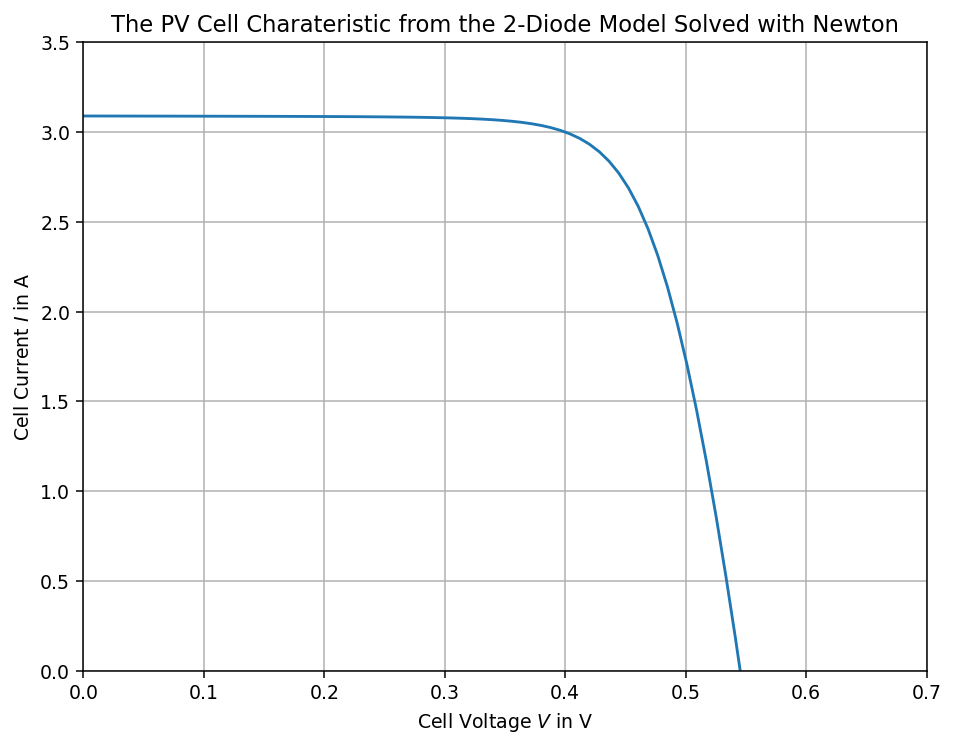

In [23]:
fig1, ax1 = plt.subplots(figsize=(8,6), dpi=136)
ax1.plot(V,I)
ax1.set_ylim(0,3.5)
ax1.set_xlim(0,0.7)
ax1.set_title(r"The PV Cell Charateristic from the 2-Diode Model Solved with Newton")
ax1.set_xlabel(r"Cell Voltage $V$ in V")
ax1.set_ylabel(r"Cell Current $I$ in A")
ax1.grid(True)